In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'

import jax.numpy as jnp
import jax
import pickle

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/chard/')

import matplotlib.pyplot as plt
from matplotlib import cm
import math

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=18)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=16, frameon=False)
plt.rc('xtick', labelsize=12, direction='in')
plt.rc('ytick', labelsize=12, direction='in')
plt.rc('figure', figsize=(6, 4))

cmap = cm.get_cmap('tab10')
color_dict = {'chard': 'red', 'mmd': 'steelblue', 'kale': 'forestgreen', 'chi2': 'purple'}
alpha = 0.1

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *


/tmp/ipykernel_396368/2625702814.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

In [2]:
def check_items_in_filename(filename, items):
    results = {}
    for item in items:
        results[item] = item in filename
    return results

trajectorys = {'mmd': None,
               'chard': None,
               'kale': None,
               'chi2': None}

configs = {'mmd': None,
              'chard': None,
              'kale': None,
              'chi2': None}

labels = {'mmd': r'$\text{MMD}^2(\cdot | \pi)$',
          'chard': r'$\text{DrMMD}(\cdot | \pi)$',
          'wass': r'$W_2(\cdot | \pi)$',}

In [3]:
def generate_three_ring_and_gaussian(Nx, Ny):
    rng_key = jax.random.PRNGKey(42)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y


In [4]:
mmd_dir = '/home/zongchen/chard/results_rebuttal/ThreeRing_dataset/Gaussian_kernel/mmd_flow/'
mmd_hyper = ['step_size_0.1_',
               'bandwidth_0.15_',
               'step_num_1000_',
               'source_particle_num_300_',
               'opt_sgd_']
mmd_trajectory = None
for file in os.listdir(mmd_dir):
    if all(hyper in file for hyper in mmd_hyper):
        mmd_trajectory = jnp.load(mmd_dir + file + '/Ys.npy')
        mmd_config = pickle.load(open(mmd_dir + file + '/configs', 'rb'))
        
if mmd_trajectory is None:
    raise ValueError('No mmd trajectory found')


In [5]:
chard_dir = '/home/zongchen/chard/results_rebuttal/ThreeRing_dataset/Gaussian_kernel/chard_flow/'
chard_hyper = ['lmbda_0.001_', 
               'step_size_0.0001_',
               'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'inject_noise_scale_0.0_',
               'nystrom_0',
               'opt_sgd_']
chard_trajectory = None
for file in os.listdir(chard_dir):
    if all(hyper in file for hyper in chard_hyper):
        chard_trajectory = jnp.load(chard_dir + file + '/Ys.npy')
        chard_config = pickle.load(open(chard_dir + file + '/configs', 'rb'))
        
if chard_trajectory is None:
    raise ValueError('No chard trajectory found')

chard_trajectory = chard_trajectory[::10]

In [6]:
kale_dir = '/home/zongchen/chard/kale-flow/Ys.npy'
kale_trajectory = jnp.load(kale_dir)[::10]

print(kale_trajectory.shape)

(100, 300, 2)


In [13]:
chi2_dir = '/home/zongchen/chard/results_rebuttal/Ys.npy'
chi2_trajectory = jnp.load(chi2_dir)[::10]
print(chi2_trajectory.shape)

(100, 300, 2)


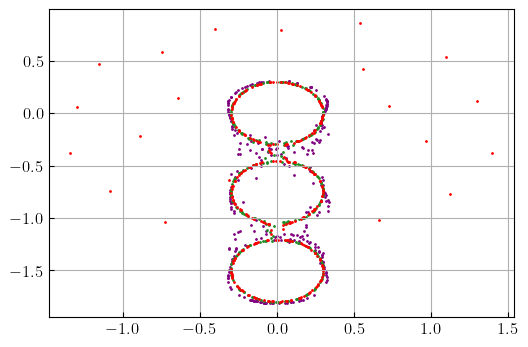

In [18]:
plt.figure()
plt.scatter(chi2_trajectory[-1, :, 0], chi2_trajectory[-1, :, 1], s=1, c='purple')
plt.scatter(kale_trajectory[-1, :, 0], kale_trajectory[-1, :, 1], s=1, c='forestgreen')
plt.scatter(mmd_trajectory[-1, :, 0], mmd_trajectory[-1, :, 1], s=1, c='red')
plt.show()

In [8]:
import argparse

# Define your dictionary
my_dict = chard_config

# Create the ArgumentParser object
parser = argparse.ArgumentParser(description='Convert dictionary to parser arguments')

# Add arguments to the parser based on the dictionary
for key, value in my_dict.items():
    # Determine the type of the value for proper handling
    if isinstance(value, int):
        parser.add_argument(f'--{key}', type=int, default=value, help=f'{key} (default: {value})')
    else:
        parser.add_argument(f'--{key}', type=str, default=value, help=f'{key} (default: "{value}")')

# Parse command line arguments (this line is for demonstration and typically uses sys.argv)
args = parser.parse_args([])  # Empty list simulates no command-line arguments




In [9]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(config, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(args, kernel, None)
    mmd_divergence.pre_compute(target)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    chard_divergence = chard_fixed_target(args, kernel, None)
    chard_divergence.pre_compute(target)
    chard_distance = jax.vmap(chard_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, chard_distance, wass_distance

In [10]:

trajectorys['mmd'] = mmd_trajectory
configs['mmd'] = mmd_config
trajectorys['chard'] = chard_trajectory
configs['chard'] = chard_config
trajectorys['kale'] = kale_trajectory
configs['kale'] = chard_config
trajectorys['chi2'] = chi2_trajectory

wasserstein_distance_all = {'mmd': {},
                            'chard': {},
                            'wass': {},}

for method, trajectory in trajectorys.items():
    T = trajectory.shape[0]
    particle_num = trajectory.shape[1]

    target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
    kernel = gaussian_kernel(0.15)
    mmd, chard, wass = compute_all_distance_trajectory(configs[method], trajectory, target, kernel)
    wasserstein_distance_all['mmd'][method] = mmd
    wasserstein_distance_all['chard'][method] = chard
    wasserstein_distance_all['wass'][method] = wass
    

In [11]:
wasserstein_distance_all['wass']['chi2'].shape

(100,)

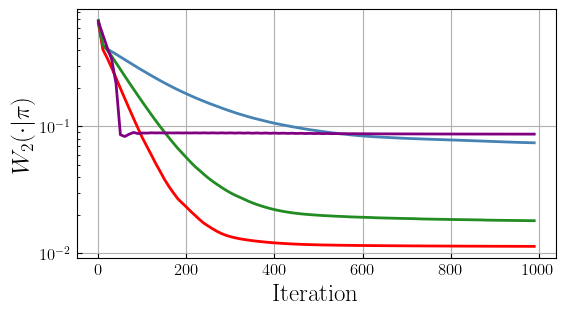

In [20]:
labels_dict = {'mmd': 'MMD', 'chard': 'DrMMD', 'kale': 'KALE', 'chi2': 'LL'}

x_ticks = jnp.arange(0, 10* T, 10)

fig, axs = plt.subplots(1, 1, figsize=(6, 3.5))
# for i, distance in enumerate(wasserstein_distance_all.keys()):
#     axs[i].set_xlabel('Iteration')
#     axs[i].set_ylabel(labels[distance])
#     for method in wasserstein_distance_all[distance].keys():
#         axs[i].plot(x_ticks, wasserstein_distance_all[distance][method], color=color_dict[method], label=labels_dict[method])
#     if i == 2:
#         axs[i].set_ylim([4e-3, 1.0])
#     axs[i].set_yscale('log')
# axs[2].legend(ncol=2)
for method in wasserstein_distance_all['wass'].keys():
    axs.plot(x_ticks, wasserstein_distance_all['wass'][method], color=color_dict[method], label=labels_dict[method])
axs.set_yscale('log')
axs.set_xlabel('Iteration')
axs.set_ylabel(r'$W_2(\cdot | \pi)$')
axs.legend(ncol=2)
plt.tight_layout()
plt.savefig(f'/home/zongchen/chard/figures/three_ring_mmd_chard_wass_ll.pdf')
plt.show()